# Além da separação linear na classificação

Como vimos na seção de regressão, o modelo de classificação linear
espera que os dados sejam linearmente separáveis. Quando esta suposição não
espera, o modelo não é expressivo o suficiente para se ajustar adequadamente aos dados.
Portanto, precisamos aplicar os mesmos truques da regressão: recurso
aumento (potencialmente usando conhecimento especializado) ou usando um
método baseado em kernel.

Forneceremos exemplos onde usaremos uma máquina de vetores de suporte a kernel
para realizar a classificação em alguns conjuntos de dados de brinquedo onde é impossível
encontre uma separação linear perfeita.

Primeiro, redefinimos nossa utilidade de plotagem para mostrar o limite de decisão de um
classificador.

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

Iremos gerar um primeiro conjunto de dados onde os dados são representados como dois
semicírculo entrelaçado. Este conjunto de dados é gerado usando a função
[`sklearn.datasets.make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [2]:
import pandas as pd
from sklearn.datasets import make_moons

feature_names = ["Feature #0", "Features #1"]
target_name = "class"

X, y = make_moons(n_samples=100, noise=0.13, random_state=42)

# We store both the data and target in a dataframe to ease plotting
moons = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1),
                     columns=feature_names + [target_name])
data_moons, target_moons = moons[feature_names], moons[target_name]

range_features_moons = {"Feature #0": (-2, 2.5), "Feature #1": (-2, 2)}

Uma vez que o conjunto de dados contém apenas dois recursos, podemos fazer um gráfico de dispersão para
dê uma olhada nisso.

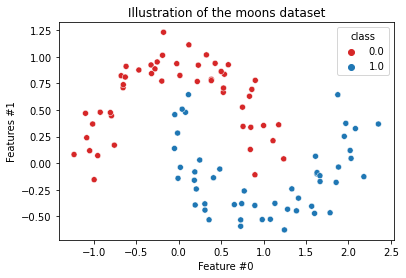

In [3]:
import seaborn as sns

sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                hue=target_moons, palette=["tab:red", "tab:blue"])
_ = plt.title("Illustration of the moons dataset")

Pelas intuições que obtivemos estudando o modelo linear, deve ser
óbvio que um classificador linear não será capaz de encontrar uma decisão perfeita
função para separar as duas classes.

Vamos tentar ver qual é o limite de decisão desse classificador linear.
Vamos criar um modelo preditivo padronizando o conjunto de dados seguido por
um classificador de máquina de vetor de suporte linear.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

linear_model = make_pipeline(StandardScaler(), SVC(kernel="linear"))
linear_model.fit(data_moons, target_moons)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p class="last"> Esteja ciente de que ajustamos e verificaremos a decisão de limite do classificador
no mesmo conjunto de dados sem dividir o conjunto de dados em um conjunto de treinamento e um
conjunto de teste. Embora seja uma prática ruim, nós a usamos por causa de
simplicidade para representar o comportamento do modelo. Sempre use validação cruzada quando
você deseja avaliar o desempenho estatístico de um modelo de aprendizado de máquina. </p>
</div>

Vamos verificar o limite de decisão de tal modelo linear neste conjunto de dados.

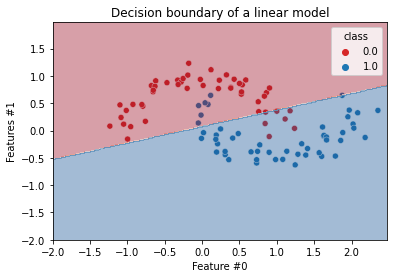

In [5]:
ax = sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                     hue=target_moons, palette=["tab:red", "tab:blue"])
plot_decision_function(linear_model, range_features_moons, ax=ax)
_ = plt.title("Decision boundary of a linear model")

Como esperado, um limite de decisão linear não é suficientemente flexível para dividir o
duas aulas.

Para levar este exemplo ao limite, criaremos outro conjunto de dados onde
as amostras de uma classe serão rodeadas por amostras da outra classe.

In [6]:
from sklearn.datasets import make_gaussian_quantiles

feature_names = ["Feature #0", "Features #1"]
target_name = "class"

X, y = make_gaussian_quantiles(
    n_samples=100, n_features=2, n_classes=2, random_state=42)
gauss = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1),
                     columns=feature_names + [target_name])
data_gauss, target_gauss = gauss[feature_names], gauss[target_name]

range_features_gauss = {"Feature #0": (-4, 4), "Feature #1": (-4, 4)}

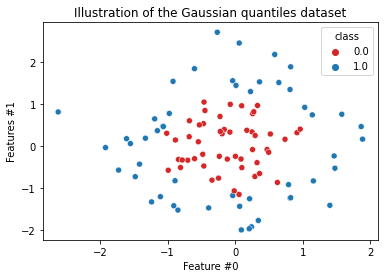

In [7]:
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
_ = plt.title("Illustration of the Gaussian quantiles dataset")

Aqui, é ainda mais óbvio que uma função de decisão linear não é
adaptado. Podemos verificar qual função de decisão, uma máquina de vetor de suporte linear
vai encontrar.

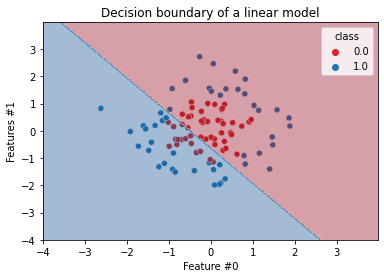

In [8]:
linear_model.fit(data_gauss, target_gauss)
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
plot_decision_function(linear_model, range_features_gauss, ax=ax)
_ = plt.title("Decision boundary of a linear model")

Como esperado, uma separação linear não pode ser usada para separar as classes
corretamente: o modelo não caberá, pois cometerá erros mesmo em
o conjunto de treinamento.

Na seção sobre regressão linear, vimos que poderíamos usar vários
truques para tornar um modelo linear mais flexível, aumentando os recursos ou
usando um kernel. Aqui, usaremos a solução posterior usando uma base radial
kernel de função (RBF) junto com um classificador de máquina de vetor de suporte.

Vamos repetir os dois experimentos anteriores e verificar a decisão obtida
função.

In [9]:
kernel_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=5))

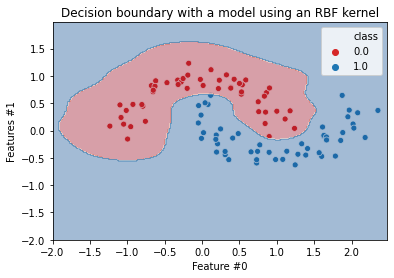

In [10]:
kernel_model.fit(data_moons, target_moons)
ax = sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                     hue=target_moons, palette=["tab:red", "tab:blue"])
plot_decision_function(kernel_model, range_features_moons, ax=ax)
_ = plt.title("Decision boundary with a model using an RBF kernel")

Vemos que o limite de decisão não é mais uma linha reta. De fato,
uma área é definida em torno das amostras vermelhas e podemos imaginar que esta
classificador deve ser capaz de generalizar em dados não vistos.

Vamos verificar a função de decisão no segundo conjunto de dados.

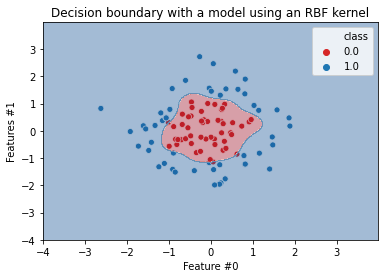

In [11]:
kernel_model.fit(data_gauss, target_gauss)
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
plot_decision_function(kernel_model, range_features_gauss, ax=ax)
_ = plt.title("Decision boundary with a model using an RBF kernel")

Observamos algo semelhante ao caso anterior. A função de decisão
é mais flexível e não é mais insuficiente.

Assim, o truque do kernel ou expansão de recursos são os truques para fazer uma
classificador mais expressivo, exatamente como vimos na regressão.

Lembre-se de que adicionar flexibilidade a um modelo também pode aumentar o risco
overfitting tornando a função de decisão sensível ao indivíduo
(possivelmente ruidoso) pontos de dados do conjunto de treinamento. Aqui podemos observar que
as funções de decisão permanecem suaves o suficiente para preservar uma boa generalização.
Se você estiver curioso, pode tentar repetir a experiência acima com
`gamma = 100` e observe as funções de decisão.